# Red Neuronal Recurrente

## Preprocesado de datos

### Importación de librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data, wb
import datetime

### Training set

In [2]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2016,1,1)
dataset_train = data.DataReader('SAN.MC', 'yahoo', start, end).drop(['High','Low','Open','Volume','Adj Close'],axis=1).rename(columns={'Close':'SAN'})
training_set = dataset_train.values

### Feature Scaling

In [3]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [4]:
training_set_scaled.shape[0]

1535

### Creación de estructura.
Este es el paso mas importante pues aquí definimos de qué exactamente aprende la red neuronal. En este caso al escoger el paso teporal igual a sesenta, la red neuronal se fija en los 60 pasos anteriores para predecir un tiempo T. Este valor se obtiene probando que la red consiga captar toda la información necesaria sin ser sobreentrenada. Por lo tanto para obtener una predicción la red se fija en lo ocurrido durante los dos meses anteriores.

In [5]:
X_train = []
y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Construyendo y entrenando la RNN

### Importación de Keras y librerías

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Se define la red neuronal de manera recurrente, se busca un modelo con muchas unidades de celdas LSTM pues se quiere que este modelo sea robusto. Se añaden capas de Dropout que permiten regularizar y evitar el overfitting.

In [8]:
regressor = Sequential()

In [9]:
# Capa de entrada
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Capas interiores
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Capa final
regressor.add(Dense(units = 1))

### Compilación de RNN
Para RNN se prueba entre adam y rms , puesto que estamos haciendo regresiones se usa mse

In [10]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Entrenamiento

In [11]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
47/47 [==============================] - 11s 103ms/step - loss: 0.0203
Epoch 2/100
47/47 [==============================] - 6s 118ms/step - loss: 0.0055
Epoch 3/100
47/47 [==============================] - 5s 99ms/step - loss: 0.0047
Epoch 4/100
47/47 [==============================] - 5s 96ms/step - loss: 0.0043
Epoch 5/100
47/47 [==============================] - 5s 97ms/step - loss: 0.0041
Epoch 6/100
47/47 [==============================] - 4s 95ms/step - loss: 0.0041
Epoch 7/100
47/47 [==============================] - 5s 103ms/step - loss: 0.0044
Epoch 8/100
47/47 [==============================] - 4s 95ms/step - loss: 0.0033
Epoch 9/100
47/47 [==============================] - 5s 104ms/step - loss: 0.0034
Epoch 10/100
47/47 [==============================] - 5s 107ms/step - loss: 0.0033
Epoch 11/100
47/47 [==============================] - 5s 107ms/step - loss: 0.0031
Epoch 12/100
47/47 [==============================] - 5s 112ms/step - loss: 0.0032
Epoch 13/100
47/4

Epoch 99/100
47/47 [==============================] - 7s 142ms/step - loss: 8.0305e-04
Epoch 100/100
47/47 [==============================] - 4s 95ms/step - loss: 8.3434e-04


## Predicciones

### Test set
Primer trimestre de 2016

In [12]:
start_test = datetime.datetime(2016, 1, 1)
end_test = datetime.datetime(2016,3,29)
dataset_test = data.DataReader('SAN.MC', 'yahoo', start_test, end_test).drop(['High','Low','Open','Volume','Adj Close'],axis=1).rename(columns={'Close':'SAN'})
real_stock_price = dataset_test.values
real_stock_price.shape

(60, 1)

### Obtención de predicciones

In [13]:
dataset_total = pd.concat((dataset_train['SAN'], dataset_test['SAN']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 120):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### Visualizando los resultados

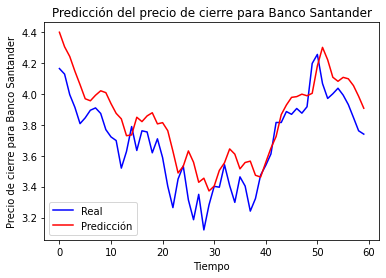

In [14]:
plt.plot(real_stock_price, color = 'blue', label = 'Real')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicción')
plt.title('Predicción del precio de cierre para Banco Santander')
plt.xlabel('Tiempo')
plt.ylabel('Precio de cierre para Banco Santander')
plt.legend()
plt.show()

rnn = predicted_stock_price
real = real_stock_price

In [15]:
from datetime import date, timedelta
delta = end_test - start_test    
dates = []
for i in range(delta.days + 1):
    day = start_test + timedelta(days=i)
    if(day.weekday()<5):dates.append(day)
    
dates = np.array(dates[:-3])
dates.shape
test = np.array((dates, real.reshape(60), rnn.reshape(60))).transpose()
df_rnn =  pd.DataFrame(test).rename(columns={0:'Fecha',1:'RNN',2:'real'}).set_index('Fecha')
df_rnn.to_csv('prediccion3.csv')